In [27]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
def visualize_images(original, transformed_gray, transformed_color):
    plt.figure(figsize=(12, 6))

    # 显示原始彩色图像
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    plt.axis('off')

    # 显示透视变换后的灰度图像
    plt.subplot(1, 3, 2)
    plt.imshow(transformed_gray, cmap='gray')
    plt.title('Perspective Transformed Gray Chessboard')
    plt.axis('off')

    # 显示透视变换后的彩色图像
    plt.subplot(1, 3, 3)
    plt.imshow(cv2.cvtColor(transformed_color, cv2.COLOR_BGR2RGB))
    plt.title('Perspective Transformed Color Chessboard')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

In [28]:
pic_file = "./pic_all/25-_rId4_542.png"
im_bgr = cv2.imread(pic_file)  # 原始的彩色图像文件，BGR模式
im_gray = cv2.cvtColor(im_bgr, cv2.COLOR_BGR2GRAY)  # 转灰度图像
im_gray = cv2.GaussianBlur(im_gray, (3, 3), 0)  # 灰度图像滤波降噪
im_edge = cv2.Canny(im_gray, 30, 50)  # 边缘检测获得边缘图像

In [29]:
def find_chessboard(im_edge, im_gray, im_bgr):
    contours, hierarchy = cv2.findContours(im_edge, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    area = 0
    rect = None

    for item in contours:
        hull = cv2.convexHull(item)
        epsilon = 0.1 * cv2.arcLength(hull, True)
        approx = cv2.approxPolyDP(hull, epsilon, True)

        if len(approx) == 4 and cv2.isContourConvex(approx):
            ps = np.reshape(approx, (4, 2))
            ps = ps[np.lexsort((ps[:, 0],))]
            lt, lb = ps[:2][np.lexsort((ps[:2, 1],))]
            rt, rb = ps[2:][np.lexsort((ps[2:, 1],))]

            a = cv2.contourArea(approx)
            if a > area:
                area = a
                rect = (lt-9, lb-9, rt-9, rb-9) #调整目标角点的位置

    if rect is not None:
        pts1 = np.float32([(10, 10), (10, 650), (650, 10), (650, 650)])
        pts2 = np.float32(rect)
        m = cv2.getPerspectiveTransform(pts2, pts1)
        board_gray = cv2.warpPerspective(im_gray, m, (680, 680)) #这里我将画面改大，适应你的图像
        board_bgr = cv2.warpPerspective(im_bgr, m, (680, 680))
        visualize_images(im_bgr, board_gray, board_bgr)
        return board_gray, board_bgr
    else:
        return None

def location_grid(board_gray, board_bgr):
    if board_gray is None:
        return None, None

    circles = cv2.HoughCircles(board_gray, cv2.HOUGH_GRADIENT, 1, 20, param1=90, param2=16, minRadius=10,
                               maxRadius=20)
    xs, ys = circles[0, :, 0], circles[0, :, 1]
    xs.sort()
    ys.sort()

    k = 1
    while xs[k] - xs[:k].mean() < 15:
        k += 1
    x_min = int(round(xs[:k].mean()))

    k = 1
    while ys[k] - ys[:k].mean() < 15:
        k += 1
    y_min = int(round(ys[:k].mean()))

    k = -1
    while xs[k:].mean() - xs[k - 1] < 15:
        k -= 1
    x_max = int(round(xs[k:].mean()))

    k = -1
    while ys[k:].mean() - ys[k - 1] < 15:
        k -= 1
    y_max = int(round(ys[k:].mean()))

    if abs(600 - (x_max - x_min)) < abs(600 - (y_max - y_min)):
        v_min, v_max = x_min, x_max
    else:
        v_min, v_max = y_min, y_max

    pts1 = np.float32([[22, 22], [22, 598], [598, 22], [598, 598]])  # 棋盘四个角点的最终位置
    pts2 = np.float32([(v_min, v_min), (v_min, v_max), (v_max, v_min), (v_max, v_max)])
    m = cv2.getPerspectiveTransform(pts2, pts1)
    board_gray = cv2.warpPerspective(board_gray, m, (620, 620))
    board_bgr = cv2.warpPerspective(board_bgr, m, (620, 620))
    visualize_images(im_bgr, board_gray, board_bgr)
    print(board_gray.shape)
    return board_gray, board_bgr

def identify_chessman(board_gray, board_bgr):
    try:
        if board_gray is None:
            return None

        mesh = np.linspace(22, 598, 19, dtype=np.int_)
        rows, cols = np.meshgrid(mesh, mesh)
        #print("Rows shape:", rows.shape)
        #print("Cols shape:", cols.shape)

        circles = cv2.HoughCircles(board_gray, cv2.HOUGH_GRADIENT, 1, 20, param1=40, param2=10, minRadius=12,
                                   maxRadius=18)
        circles = np.uint32(np.around(circles[0]))

        phase = np.zeros_like(rows, dtype=np.uint8)
        im_hsv = cv2.cvtColor(board_bgr, cv2.COLOR_BGR2HSV_FULL)

        for circle in circles:
            row = int(round((circle[1] - 22) / 32))
            col = int(round((circle[0] - 22) / 32))
            #print("Row:", row)
            #print("Col:", col)
            hsv_ = im_hsv[cols[row, col] - 5:cols[row, col] + 5, rows[row, col] - 5:rows[row, col] + 5]
            s = np.mean(hsv_[:, :, 1])
            v = np.mean(hsv_[:, :, 2])

            if 0 < v < 150:
                phase[row, col] = 1
            elif 0 < s < 90 and 114 < v < 256:
                phase[row, col] = 2

        return phase
    except Exception as e:
        print("An error occurred:", str(e))

def process_chessboard_image(pic_file, offset=3.75):
    im_bgr = cv2.imread(pic_file)
    im_gray = cv2.cvtColor(im_bgr, cv2.COLOR_BGR2GRAY)
    im_gray = cv2.GaussianBlur(im_gray, (3, 3), 0)
    im_edge = cv2.Canny(im_gray, 30, 50)

    board_gray, board_bgr = find_chessboard(im_edge, im_gray, im_bgr)
    #board_gray, board_bgr = im_gray, im_bgr
    if board_gray is None:
        return None, None, None

    board_gray, board_bgr = location_grid(board_gray, board_bgr)
    phase = identify_chessman(board_gray, board_bgr)
    if phase is not None:
        print(phase.shape)
    return board_gray, board_bgr, phase

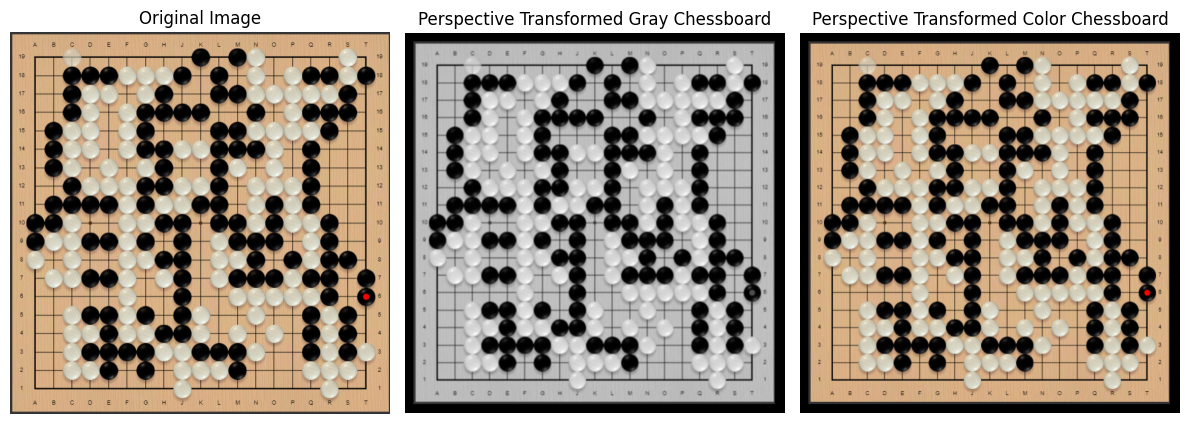

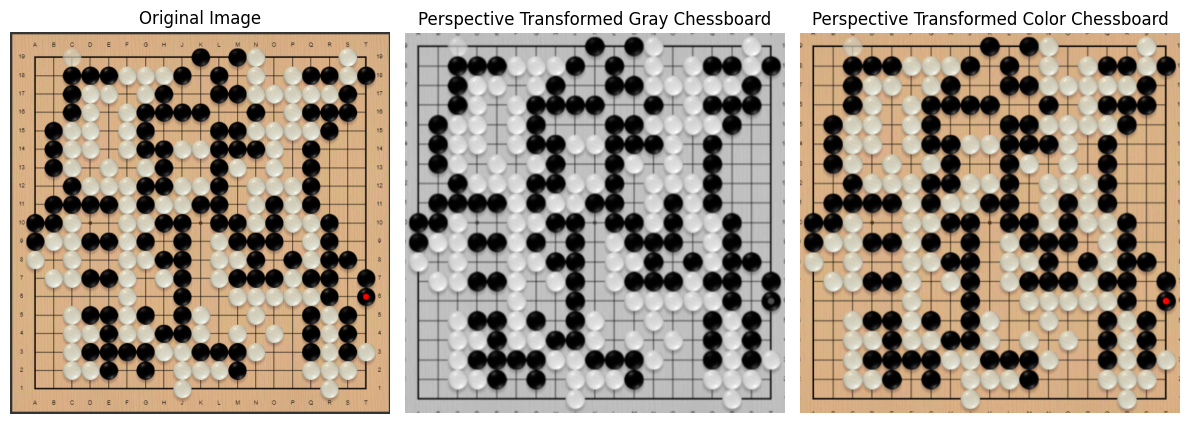

(620, 620)
(19, 19)


(array([[180, 184, 184, ..., 181, 182, 183],
        [180, 183, 183, ..., 181, 182, 183],
        [181, 183, 183, ..., 181, 182, 183],
        ...,
        [185, 184, 181, ..., 179, 181, 184],
        [185, 183, 180, ..., 180, 181, 184],
        [184, 182, 179, ..., 179, 181, 184]], dtype=uint8),
 array([[[128, 171, 214],
         [133, 176, 219],
         [133, 178, 221],
         ...,
         [132, 174, 213],
         [132, 173, 212],
         [136, 177, 216]],
 
        [[129, 172, 215],
         [133, 176, 219],
         [133, 177, 220],
         ...,
         [131, 174, 213],
         [132, 174, 213],
         [136, 177, 216]],
 
        [[129, 172, 215],
         [133, 176, 219],
         [130, 175, 218],
         ...,
         [130, 174, 213],
         [132, 175, 214],
         [135, 177, 216]],
 
        ...,
 
        [[137, 179, 222],
         [136, 178, 221],
         [129, 171, 213],
         ...,
         [127, 170, 213],
         [130, 172, 215],
         [136, 177, 220]

In [30]:
process_chessboard_image(pic_file)

In [5]:
import cv2
import numpy as np
from sklearn.cluster import KMeans

# 读取图片
image = cv2.imread('./pic_all/1-1_rId4_0.png')

# 将图片转换为灰度图
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# 使用Canny边缘检测
edges = cv2.Canny(gray, 50, 150, apertureSize=3)

# 在边缘图上进行霍夫变换检测直线
lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=100, minLineLength=750, maxLineGap=10)

# 获取直线的端点，即边角坐标
corners = []
for line in lines:
    x1, y1, x2, y2 = line[0]
    corners.append((x1, y1))
    corners.append((x2, y2))

# 计算每个点与图像中心的距离的平方
image_center = (image.shape[1] // 2, image.shape[0] // 2)
corners_with_distance = [(corner, (corner[0] - image_center[0]) ** 2 + (corner[1] - image_center[1]) ** 2) for corner in corners]

# 按距离排序，选择离图像中心较近的四个点
corners_with_distance.sort(key=lambda x: x[1])
selected_corners = [corner[0] for corner in corners_with_distance[:100]]

# 使用K均值聚类进行点的合并
kmeans = KMeans(n_clusters=4)
kmeans.fit(selected_corners)
cluster_centers = kmeans.cluster_centers_.astype(int)
# 在原图上标记选定的边角坐标
for corner in cluster_centers:
    x, y = corner
    cv2.circle(image, (x, y), 5, (0, 255, 0), -1)  # 在图上画绿色的小圆


# 根据聚类结果获取四个点的坐标
top_left = min(cluster_centers, key=lambda x: x[0] + x[1])
top_right = max(cluster_centers, key=lambda x: x[0] - x[1])
bottom_left = min(cluster_centers, key=lambda x: x[0] - x[1])
bottom_right = max(cluster_centers, key=lambda x: x[0] + x[1])

# 计算裁剪区域的左上角和右下角坐标
start_x = min(top_left[0], bottom_left[0])
start_y = min(top_left[1], top_right[1])
end_x = max(top_right[0], bottom_right[0])
end_y = max(bottom_left[1], bottom_right[1])

# 进行裁剪操作
cropped_image = image[start_y:end_y, start_x:end_x]
gray_cropped = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2GRAY)  # 转灰度图像
gray_cropped = cv2.GaussianBlur(gray_cropped, (3, 3), 0)  # 灰度图像滤波降噪
cropped_image = cv2.resize(cropped_image,(620,620))
gray_cropped = cv2.resize(gray_cropped,(620,620))


# 在图像上绘制四个点的位置
cv2.circle(image, tuple(top_left), 5, (0, 0, 255), -1)  # 红色
cv2.circle(image, tuple(top_right), 5, (0, 255, 0), -1)  # 绿色
cv2.circle(image, tuple(bottom_left), 5, (255, 0, 0), -1)  # 蓝色
cv2.circle(image, tuple(bottom_right), 5, (255, 255, 0), -1)  # 青色

print(identify_chessman(gray_cropped,cropped_image))
# 显示带有标记点的图像
cv2.imshow('Image with Marked Points', gray_cropped)

# 等待按下任意按键后关闭窗口
cv2.waitKey(0)
cv2.destroyAllWindows()

F:\anaconda3\envs\weiqi\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 2 0 0 2 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 1 0 0 0 2 0 0 1 0 2 0 2 1 0 1 0 0]
 [0 0 1 2 0 1 1 2 0 0 1 0 0 2 1 0 0 0 0]
 [0 0 0 2 0 0 0 2 1 2 1 0 2 0 2 0 0 0 0]
 [0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 1 2 0 0 0 0 0 0 0 0 0]
 [0 1 2 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 0 2 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 1 0]
 [0 1 2 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 1 2 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 1 2 0 0 0 0 0 0 0 0 0 2 0 1 0 0 0]
 [0 0 1 2 0 0 0 0 0 2 0 0 0 0 2 2 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
